In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tvt
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from pytorch_sklearn.neural_network.neural_network import NeuralNetwork
from pytorch_sklearn.neural_network.generative_network import CycleGAN
from pytorch_sklearn.callbacks.predefined import Verbose, History, EarlyStopping
from pytorch_sklearn.utils.progress_bar import print_progress

from sonn.building_blocks import Downsample2d, Upsample2d
from sonn.norm_layers import LayerNormNLP2d
from sonn.superonn_final import SuperONN2d

from PIL import Image

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return self.conv3(x)
    
class KillerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.conv5 = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        return self.conv5(x)
    
class KillerONN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SuperONN2d(3, 32, q=3, kernel_size=3, padding=1)
        self.ds1   = Downsample2d(32)  # 32 -> 64
        self.ln1   = LayerNormNLP2d(64)
        self.conv2 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.ds2   = Downsample2d(64)  # 64 -> 128
        self.ln2   = LayerNormNLP2d(128)
        self.conv3 = SuperONN2d(128, 128, q=3, kernel_size=3, padding=1)
        self.up2   = Upsample2d(128)   # 128 -> 64
        self.ln3   = LayerNormNLP2d(64)
        self.conv4 = SuperONN2d(64, 64, q=3,  kernel_size=3, padding=1)
        self.up1   = Upsample2d(64)    # 64 -> 32
        self.ln4   = LayerNormNLP2d(32)
        self.conv5 = SuperONN2d(32, 3, q=3, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.ds1(x)
        x = self.ln1(x)
        x = F.relu(self.conv2(x))
        x = self.ds2(x)
        x = self.ln2(x)
        x = F.relu(self.conv3(x))
        x = self.up2(x)
        x = self.ln3(x)
        x = F.relu(self.conv4(x))
        x = self.up1(x)
        x = self.ln4(x)
        return self.conv5(x)
    
class SimpleDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=4)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=4)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        x = F.relu(self.maxpool1(self.conv1(x)))
        x = F.relu(self.maxpool2(self.conv2(x)))
        x = self.maxpool3(self.conv3(x))
        return x.view(-1, 1)

In [3]:
model = SimpleDiscriminator()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
crit = nn.MSELoss()

In [4]:
X = torch.randn(10, 3, 32, 32)
y = torch.randn(10, 1)

In [5]:
net = NeuralNetwork(model, optim, crit)

In [6]:
net.callbacks

In [7]:
net.fit(
    train_X=X,
    train_y=y,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'l1loss': nn.L1Loss(), 'l2loss': nn.MSELoss()},
)

Epoch 1/50
1/1 [====================] - train_loss: 1.365 - train_l1loss: 0.983 - train_l2loss: 1.365 - Time: 0.50 - ETA: 0.00
Epoch 2/50
1/1 [====================] - train_loss: 1.336 - train_l1loss: 0.954 - train_l2loss: 1.336 - Time: 0.01 - ETA: 0.00
Epoch 3/50
1/1 [====================] - train_loss: 1.304 - train_l1loss: 0.929 - train_l2loss: 1.304 - Time: 0.01 - ETA: 0.00
Epoch 4/50
1/1 [====================] - train_loss: 1.268 - train_l1loss: 0.913 - train_l2loss: 1.268 - Time: 0.01 - ETA: 0.00
Epoch 5/50
1/1 [====================] - train_loss: 1.223 - train_l1loss: 0.895 - train_l2loss: 1.223 - Time: 0.01 - ETA: 0.00
Epoch 6/50
1/1 [====================] - train_loss: 1.180 - train_l1loss: 0.878 - train_l2loss: 1.180 - Time: 0.01 - ETA: 0.00
Epoch 7/50
1/1 [====================] - train_loss: 1.137 - train_l1loss: 0.860 - train_l2loss: 1.137 - Time: 0.01 - ETA: 0.00
Epoch 8/50
1/1 [====================] - train_loss: 1.091 - train_l1loss: 0.841 - train_l2loss: 1.091 - Time: 0

In [8]:
net.predict(X)
gen = net.predict_generator(X)
for i in gen:
    print(i)
score = net.score(X, y)
print(score)

tensor([[-0.1691],
        [-1.0707],
        [ 0.2636],
        [-1.5670],
        [-0.3387],
        [-1.7453],
        [ 0.4953],
        [ 2.1261],
        [ 1.8542],
        [-0.6468]], device='cuda:0')
tensor(0.0090)


In [9]:
class CycleGANDataset(Dataset):
    def __init__(self):
        self.A = torch.randn(10, 3, 32, 32) * .1
        self.B = torch.randn(10, 3, 32, 32) * .8

    def __len__(self):
        return 10
    
    def __getitem__(self, index):
        return self.A[index], self.B[index]

In [10]:
class ZenDataset(Dataset):
    def __init__(self):
        self.Zen = tvt.ToTensor()(Image.open('zen2.jpg')).unsqueeze(0)
        self.Bro = tvt.ToTensor()(Image.open('bro.jpg')).unsqueeze(0)

    def __len__(self):
        return 1
    
    def __getitem__(self, index):
        return self.Zen[index], self.Bro[index]

In [11]:
class STDMetric:
    def __init__(self):
        self.stdA = []
        self.stdB = []
        self.stdA2B = []
        self.stdB2A = []

    def __call__(self, batch_out, batch_y):
        A2B, B2A = batch_out
        A, B = batch_y
        self.stdA.append(A.std().item())
        self.stdB.append(B.std().item())
        self.stdA2B.append(A2B.std().item())
        self.stdB2A.append(B2A.std().item())
        return 0

In [20]:
G_A = SimpleCNN()
G_B = SimpleCNN()
# G_A = KillerCNN()
# G_B = KillerCNN()
# G_A = KillerONN()
# G_B = KillerONN()
D_A = SimpleDiscriminator()
D_B = SimpleDiscriminator()

G_optim = torch.optim.Adam(list(G_A.parameters()) + list(G_B.parameters()), lr=0.001)
D_optim = torch.optim.Adam(list(D_A.parameters()) + list(D_B.parameters()), lr=0.001)

In [21]:
cycle_gan = CycleGAN(G_A, G_B, D_A, D_B, G_optim, D_optim)

In [16]:
cycle_gan_ds = CycleGANDataset()
zen_ds = ZenDataset()

In [17]:
std_metric = STDMetric()

In [23]:
cycle_gan.fit(
    train_X=cycle_gan_ds,
    max_epochs=50,
    callbacks=[Verbose(notebook=True)],
    metrics={'std': std_metric},
)

Epoch 51/100
1/1 [====================] - train_loss: 1.646 - train_std: 6.528 - Time: 0.28 - ETA: 0.00
Epoch 52/100
1/1 [====================] - train_loss: 1.634 - train_std: 6.421 - Time: 0.04 - ETA: 0.00
Epoch 53/100
1/1 [====================] - train_loss: 1.626 - train_std: 6.314 - Time: 0.03 - ETA: 0.00
Epoch 54/100
1/1 [====================] - train_loss: 1.618 - train_std: 6.213 - Time: 0.03 - ETA: 0.00
Epoch 55/100
1/1 [====================] - train_loss: 1.606 - train_std: 6.125 - Time: 0.03 - ETA: 0.00
Epoch 56/100
1/1 [====================] - train_loss: 1.590 - train_std: 6.046 - Time: 0.03 - ETA: 0.00
Epoch 57/100
1/1 [====================] - train_loss: 1.575 - train_std: 5.975 - Time: 0.03 - ETA: 0.00
Epoch 58/100
1/1 [====================] - train_loss: 1.560 - train_std: 5.902 - Time: 0.03 - ETA: 0.00
Epoch 59/100
1/1 [====================] - train_loss: 1.545 - train_std: 5.816 - Time: 0.03 - ETA: 0.00
Epoch 60/100
1/1 [====================] - train_loss: 1.533 - tr

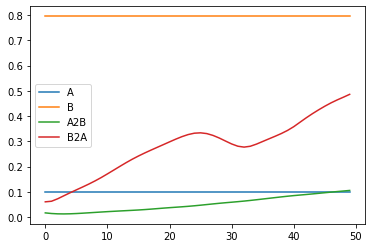

In [18]:
plt.plot(std_metric.stdA, label='A')
plt.plot(std_metric.stdB, label='B')
plt.plot(std_metric.stdA2B, label='A2B')
plt.plot(std_metric.stdB2A, label='B2A')
plt.legend()
plt.show()

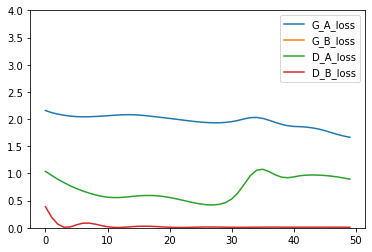

In [19]:
plt.plot(cycle_gan.history.track['train_G_A_loss'], label='G_A_loss')
plt.plot(cycle_gan.history.track['train_G_B_loss'], label='G_B_loss')
plt.plot(cycle_gan.history.track['train_D_A_loss'], label='D_A_loss')
plt.plot(cycle_gan.history.track['train_D_B_loss'], label='D_B_loss')
plt.ylim(0, 4)
plt.legend()
plt.show()

In [20]:
preds = cycle_gan.predict(cycle_gan_ds)
score = cycle_gan.score(cycle_gan_ds)
print(score)
out_gen = cycle_gan.predict_generator(cycle_gan_ds)
for i in out_gen:
    print(i.__len__())

tensor([8.1115, 0.8833])
4


In [21]:
NeuralNetwork.save_class(cycle_gan, 'cycle_gan.pkl')

In [22]:
NeuralNetwork.load_class(cycle_gan, [], 'cycle_gan.pkl')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


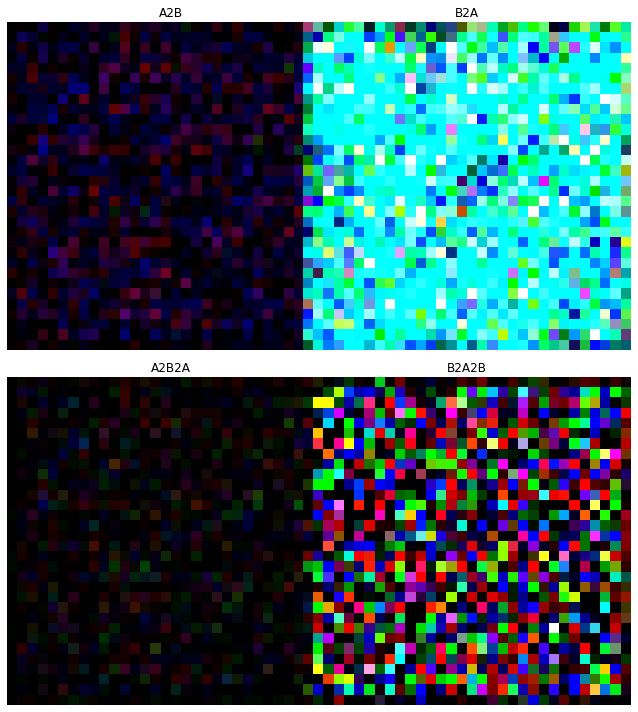

In [20]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(preds[0][0].permute(1, 2, 0).cpu(), vmin=preds[0][0].min(), vmax=preds[0][0].max())
plt.title('A2B')
plt.axis('off')
plt.subplot(2, 2, 2)
plt.imshow(preds[1][0].permute(1, 2, 0).cpu(), vmin=preds[1][0].min(), vmax=preds[1][0].max())
plt.title('B2A')
plt.axis('off')
plt.subplot(2, 2, 3)
plt.imshow(preds[2][0].permute(1, 2, 0).cpu(), vmin=preds[2][0].min(), vmax=preds[2][0].max())
plt.title('A2B2A')
plt.axis('off')
plt.subplot(2, 2, 4)
plt.imshow(preds[3][0].permute(1, 2, 0).cpu(), vmin=preds[3][0].min(), vmax=preds[3][0].max())
plt.title('B2A2B')
plt.axis('off')
plt.gcf().tight_layout(w_pad=-10)
plt.show()

In [44]:
a = {'a': 1, 'b': 2}
b = {**a, 'c': 3}
b

{'a': 1, 'b': 2, 'c': 3}

In [31]:
[pred.std() for pred in preds]

[tensor(0.7727, device='cuda:0'),
 tensor(0.0985, device='cuda:0'),
 tensor(0.0920, device='cuda:0'),
 tensor(0.7303, device='cuda:0')]

In [18]:
from typing import Iterable, Tuple, List, Sequence

In [255]:
a = []
for i in range(5):
    a.append([torch.randn(3,1,5,5), torch.randn(3,1,5,5), torch.randn(3,1,5,5), 5, 3, [1,2]])
    #a.append(torch.randn(3,1,5,5))

In [256]:
def stack_if_list_of_list(arr):
    if isinstance(arr[0], (list, tuple)):
        ret = []
        for col in zip(*arr):
            if isinstance(col[0], torch.Tensor):
                ret.append(torch.cat(col))
            else:
                ret.append(torch.tensor(np.stack(col)))
        return ret
    else:
        return torch.cat(arr)

In [258]:
stack_if_list_of_list(a)[-1]

tensor([[1, 2],
        [1, 2],
        [1, 2],
        [1, 2],
        [1, 2]], dtype=torch.int32)

In [50]:
torch.cat(a)

TypeError: expected Tensor as element 0 in argument 0, but got list

In [45]:
np.stack(a)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [55]:
np.stack(a).shape

(5, 2)

In [56]:
torch.cat(torch.tensor(a)).shape

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [40]:
torch.cat(tuple(torch.tensor(np.stack(a)))).shape

torch.Size([50, 3, 32, 32])

In [31]:
a = []
a.append([1,2,3])
a.append([1,2,3])
a.append([1,2,3])
a.append([1,2,3])
np.concatenate(a)

array([1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3])